In [1]:
import numpy as np
import os
import glob
import sys
import torch
from pathlib import Path

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(grandparent_dir)
print(grandparent_dir)

import gendata
import learner as ln
from utils import Logger, read_config_file, set_random_seed, tensors_to_numpy

from learner.metric.dynamics_metric import (
    calculate_dynamics_metrics,
    plot_dynamics_metrics,
)

/home/lbu/project/PINN_DE


In [2]:
from configs.config_plot import *

seed = 0
set_random_seed(seed)

os.makedirs(output_dir, exist_ok=True)  

# Logger
logger = Logger(output_dir)
logger.info("#" * 100)

2023-08-25 20:38:44 INFO ####################################################################################################


# system

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable

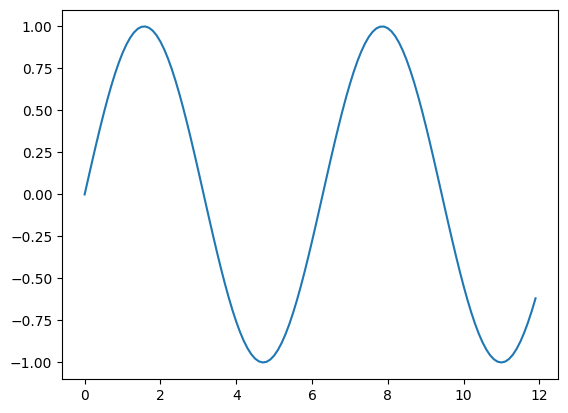

In [2]:
# 构建输入
x = np.arange(0,12,0.1,dtype=np.float32)
y = np.sin(x)
plt.plot(x,y)

In [3]:
# 下面方法用来生成输入的数据集x和y，输入是sin(x)的序列，x为(长度、1、3)长度、batch、维度的一个三维的输入数据，y是对应的后面一个sin(x)的值
def generateData(dataset,timeStep=3):
    dataX,dataY=[],[]
    for i in range(len(dataset)-timeStep):
        a = dataset[i:(i+timeStep)]
        dataX.append(a)
        dataY.append(dataset[i+timeStep])
    return np.array(dataX), np.array(dataY)

data_x,data_y = generateData(y)
# 将data变成（length，1,3）这样子的数据。length是你全部输入数据的长度。
train_X = data_x.reshape(-1, 1, 3) 
train_y = data_y.reshape(-1, 1, 1)

train_X.shape, train_y.shape

((117, 1, 3), (117, 1, 1))

In [4]:
# 构建lstm模型
class myLSTM(torch.nn.Module):
    def __init__(self):
        super(myLSTM,self).__init__()
        # input_size 就是输入数据的维度，这里的是3，因为是3个时间长度，隐藏层个数自己设置，num_layers是lstm的层数。
#         self.lstm=torch.nn.LSTM(input_size=3,hidden_size=50,num_layers=2,batch_first=True)
        self.lstm=torch.nn.LSTM(input_size=3,hidden_size=50,num_layers=2,batch_first=False)
        # 一个全连接，把50变成1
        self.liner1 = torch.nn.Linear(50,1)

    def forward(self,x):
        x,_ = self.lstm(x) # seq batch hidden
        # x[:,-1:,] 这里是取最后一个值，用来进行全连接，下面注释掉的与全连接这句的意思是一样的。
#         out = self.liner1(x[:,-1:,])
        s,b,h = x.shape
        x = x.view(s*b,h)
        x = self.liner1(x)
        out = x.view(s,b,-1)
        return out

# 构建模型，选取下降方法，选取损失函数
myNet = myLSTM() 

In [5]:
lstm_func=torch.nn.LSTM(input_size=3,hidden_size=50,num_layers=2, batch_first=False)
xx = torch.tensor(train_X,dtype=torch.float,requires_grad=True)
out,_  = lstm_func(xx)
out.shape, xx.shape

(torch.Size([117, 1, 50]), torch.Size([117, 1, 3]))

In [6]:
optimizer = torch.optim.Adamax(myNet.parameters(),lr=0.1)
criterion = torch.nn.MSELoss(reduction="mean")

# 进行迭代
for i in range(1000):
    batch_loss = []
    # 把输入和“输出标记y”都变成torch.tensor类型的。每次循环都是对所有的输入进行的训练，暂时没有用到batch。
    xx = torch.tensor(train_X, dtype=torch.float, requires_grad=True)
    yy = torch.tensor(train_y, dtype=torch.float, requires_grad=True)
    prediction = myNet(xx)
    # 计算损失值
    loss = criterion(prediction,yy)
    # 梯度清零
    optimizer.zero_grad()
    # 反向传播
    loss.backward(retain_graph=True)
    # 更新参数
    optimizer.step()
    batch_loss.append(loss.data.numpy())
    if i% 100==0:
        print(i,np.mean(batch_loss))

0 0.538419
100 1.7095788e-05
200 4.156575e-06
300 2.0085129e-06
400 1.1972463e-06
500 8.0663534e-07
600 5.9329807e-07
700 4.6729375e-07
800 3.8848202e-07
900 3.3630468e-07


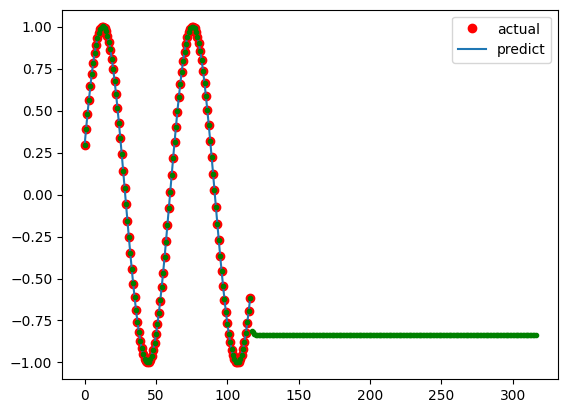

In [7]:
# 查看训练结果
trainx01 = torch.tensor(train_X,dtype=torch.float,requires_grad=True)
trainy01 = myNet(trainx01).data.numpy()
train_t = train_y.reshape(117,1) # 这个117就是 n,_,_=train_y.shape 中的n
plt.plot(train_t,'o',label='actual',linewidth=10,color='r')
trainy01 = trainy01.reshape(117,1)
plt.plot(trainy01,label='predict')
plt.legend()

# 下面的3就是上面代码中的时间步长3。这是在循环用后面三个估计第四个，然后第四个加入列表，继续循环，计200次。
storeY = trainy01
for i in range(200):
    stX = storeY[len(storeY)-3:]
    stX = stX.reshape(1,1,3)
    st_train = torch.tensor(stX,dtype=torch.float,requires_grad=True)
    st_y = myNet(st_train).data.numpy()
    st_y = (st_y[0][0])
    storeY = storeY.tolist()
    storeY.append(st_y)
    storeY = np.array(storeY)

plt.plot(storeY,'.',label='predict',color='g')